In [4]:
import torch
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt
from clustertools import *

In [5]:
from transformers import FlaubertModel, FlaubertTokenizer, FlaubertForSequenceClassification

### Charger le modèle depuis la base de données d'huggingface

On enregistre ensuite le modèle sur le disque pour ne pas avoir à le retélécharger à chaque fois

In [2]:
modelname = 'flaubert/flaubert_base_cased' 

In [10]:
flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)
flaubert.save_pretrained("flaubert_pretrained_model")

flaubert_tokenizer = FlaubertTokenizer.from_pretrained(modelname, do_lowercase=False)
flaubert_tokenizer.save_pretrained("models/flaubert_pretrained_tokenizer")

### Charger le modèle depuis le disque

In [9]:
modelname = 'models/flaubert_pretrained_model' 
tok_name = 'models/flaubert_pretrained_tokenizer'

In [10]:
flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(tok_name, do_lowercase=False)

### Fonctions pour l'encodage

In [11]:
# Fonctions prises sur le github de flaubert
# https://github.com/getalp/Flaubert

def encode_sentence(sentence):
    token_ids = torch.tensor([flaubert_tokenizer.encode(sentence)])

    last_layer = flaubert(token_ids)[0]
    return last_layer[:, 0, :]

def encode_dataset(dataset):
    dataset_encoded = []
    for tweet in dataset:
        dataset_encoded.append(encode_sentence(tweet))
    return dataset_encoded

### Petit aperçu de ce qu'il se passe

- On prend la phrase *J'aime les pâtes fraîches* pour cet exemple
- Le tokeniseur renvoie un dictionnaire a trois entrées.
  - L'entrée `input_ids` contient la phrase transformée en tokens (les tokens étant remplacés par leurs codes), sous forme de liste
  - l'entrée `token_type_ids` contient un masque qui permet de séparer deux phrases dans le cas où deux phrases sont données dans la même entrée, séparées par un token spécial. Cela n'est pas utile ici. 
  - l'entrée `attention_mask` contient les masques d'attention, cela permet au modèle de ne pas calculer l'attention pour les tokens de bourrage (padding). Ce n'est pas utile ici car il n'y a qu'une phrase en entrée, il n'y a donc pas de bourrage.
- Ce dictionnaire est donné en entrée au modèle qui renvoie un objet de type BaseModelOutput qui correspond aux phrases encodées.
  - L'expression `outp[0]` permet de récupérer le tenseur correspondant à l'encodage de notre phrase.
  - Ce tenseur correspond bien à un tenseur de forme (1, 7, 768) soit 1 message de 7 tokens encodés en 768 dimensions
  - On ne souhaite garder que l'encodage correspondant au premier token qui est un token spécial appelé token de classification et qui correspond donc à un encodage de la séquence entière, on utilise donc l'expression `outp[0][:, 0, :]`

In [39]:
sentences = ["J'aime les pâtes fraîches"]

In [40]:
batch = flaubert_tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [41]:
batch

{'input_ids': tensor([[    0,   158,   735,    22, 10177, 14310,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [42]:
with torch.no_grad():
    outp = flaubert(**batch)
outp

BaseModelOutput(last_hidden_state=tensor([[[-1.5572, -0.0890, -1.3929,  ..., -0.2964,  0.6465,  2.1243],
         [-1.3848,  0.3356, -1.5585,  ..., -0.6167,  0.9209,  2.1265],
         [-1.4799,  0.3328, -2.0771,  ..., -0.5592,  0.3642,  1.7878],
         ...,
         [-1.2185,  0.2984, -1.2819,  ..., -1.2340,  0.7811,  1.1475],
         [-1.2855,  0.5238, -1.4951,  ..., -1.4727,  0.6563,  1.3550],
         [-1.1542,  0.4628, -1.3938,  ..., -1.6033,  0.6594,  1.4823]]]), hidden_states=None, attentions=None)

In [43]:
outp[0]

tensor([[[-1.5572, -0.0890, -1.3929,  ..., -0.2964,  0.6465,  2.1243],
         [-1.3848,  0.3356, -1.5585,  ..., -0.6167,  0.9209,  2.1265],
         [-1.4799,  0.3328, -2.0771,  ..., -0.5592,  0.3642,  1.7878],
         ...,
         [-1.2185,  0.2984, -1.2819,  ..., -1.2340,  0.7811,  1.1475],
         [-1.2855,  0.5238, -1.4951,  ..., -1.4727,  0.6563,  1.3550],
         [-1.1542,  0.4628, -1.3938,  ..., -1.6033,  0.6594,  1.4823]]])

In [44]:
outp[0].shape

torch.Size([1, 7, 768])

In [45]:
outp[0][:, 0, :].shape

torch.Size([1, 768])

### Utilisation du modèle sur un cluster 
#### Chargement des données
Le cluster choisi est un cluster intéressant car comportant beaucoup de mots-clés haineux

In [46]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_Std_clusters/som_400/"

raw_dataset_file = "clusters/1M_Std_clusters/som_400/som_400_cluster_349_raw_msg.txt"

In [47]:
with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()
    
clean_dataset = [line.split() for line in raw_dataset]

#### Encodage du cluster

In [48]:
%%time
encoded_dataset = encode_dataset(raw_dataset)

CPU times: user 2min 3s, sys: 6.09 s, total: 2min 9s
Wall time: 33.9 s


#### Visualisation 

In [49]:
from sklearn.decomposition import PCA

In [55]:
# Transformation du dataset en tenseur numpy
np_encoded_dataset = np.array([e[0].detach().numpy() for e in encoded_dataset])

In [51]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(np_encoded_dataset)

CPU times: user 717 ms, sys: 1.59 s, total: 2.3 s
Wall time: 591 ms


In [52]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.markersize"] = 3

In [53]:
init_globals(clean_dataset, raw_dataset, two_dim_dataset, cluster_dir)

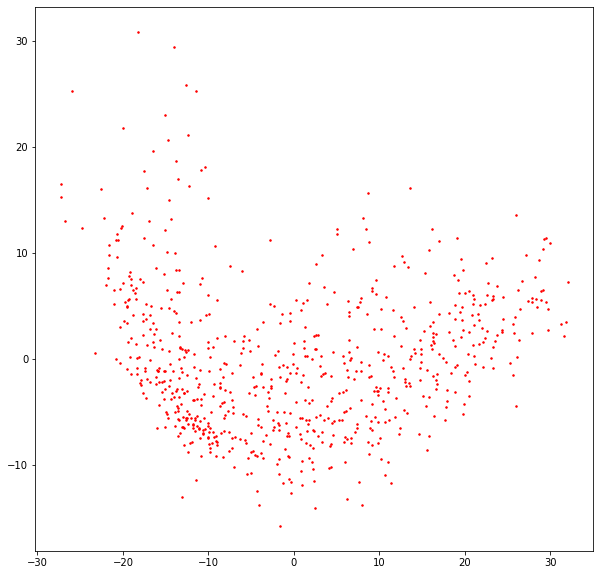

In [54]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### Clustering avec SOM

In [56]:
from minisom import MiniSom

In [77]:
m = 4
n = 4
som = MiniSom(m, n, 768, neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(np_encoded_dataset)

/home/victor/data/fidle/fidle-env/lib/python3.9/site-packages/minisom.py:379: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


In [78]:
%%time
som.train(np_encoded_dataset, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 21.549240312911035
CPU times: user 19.6 s, sys: 2.77 s, total: 22.4 s
Wall time: 18.9 s


In [79]:
%%time
pred = []
for msg in np_encoded_dataset:
    winner = som.winner(msg)
    pred.append(winner[0]*n+winner[1])

CPU times: user 54.3 ms, sys: 194 µs, total: 54.5 ms
Wall time: 51.4 ms


Cluster 0 : 23 messages
3 messages contiennent un mot-clé haineux (soit 13.04%)
Les 20 mots les plus fréquents : On comment mon Mais va leur s'en bat flots Eren raconte morteReiner: https://t.co/RMoA9yftjv tel tellement https://t.co/Ae2nO5yNih trahis nous Sa enfer 


Cluster 1 : 73 messages
21 messages contiennent un mot-clé haineux (soit 28.77%)
Les 20 mots les plus fréquents : te mais C’est Ma tu fait sur trop quand ton avec « lui #SPACEAFROOO Sale Les clash Moi j’ai baiser 


Cluster 2 : 21 messages
5 messages contiennent un mot-clé haineux (soit 23.81%)
Les 20 mots les plus fréquents : me 👍 se stp ...😂 Chelou Des du caca 💩 aussi 😂 Ça fait vraiment pleurer mon père Le mari 


Cluster 3 : 16 messages
0 messages contiennent un mot-clé haineux (soit 0.00%)
Les 20 mots les plus fréquents : Oh Future indigne Ma m’énerve oh j’suis dégoûté sbmm mais c Moi perso avec Après suis lewandowski mérit largement Espèce 


Cluster 4 : 15 messages
3 messages contiennent un mot-clé haineux (soit 20.0

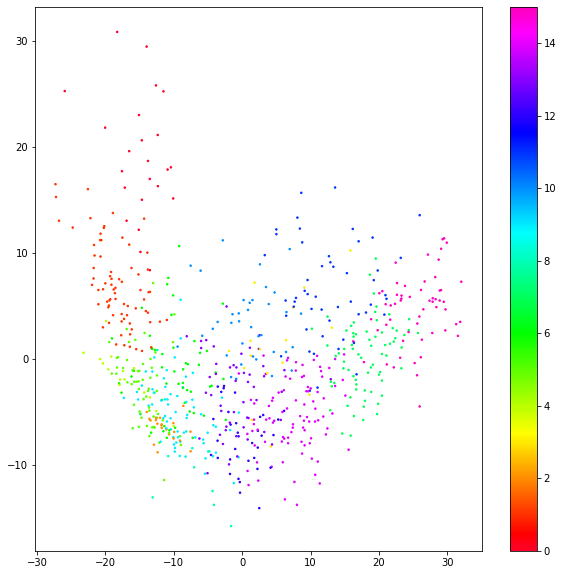

In [81]:
parse_results(pred, "minisom_16_flaubert", [])

### Kmeans

In [65]:
n_clust = 4

In [66]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(np_encoded_dataset)

CPU times: user 3.66 s, sys: 3.15 s, total: 6.81 s
Wall time: 1 s


In [67]:
km_pred = kmeans.predict(np_encoded_dataset)

Cluster 0 : 174 messages
35 messages contiennent un mot-clé haineux (soit 20.11%)
Les 20 mots les plus fréquents : niquez te bz j’ai Les tout mer c'est si enculé lui me suis TA MÈRE sale Mais comme mdr va 


Cluster 1 : 245 messages
58 messages contiennent un mot-clé haineux (soit 23.67%)
Les 20 mots les plus fréquents : Oh tu fait trop sale vie MÈRE suis SA #SPACEAFROOO ce lui bz aussi mais mer va niquez pour Les 


Cluster 2 : 91 messages
23 messages contiennent un mot-clé haineux (soit 25.27%)
Les 20 mots les plus fréquents : On te mais mon leur Ma Les sur comment Moi trop Mais c vie y’a dans qu’il va bz quand 


Cluster 3 : 218 messages
54 messages contiennent un mot-clé haineux (soit 24.77%)
Les 20 mots les plus fréquents : pour dit elle plus Ma « sale tu du me va salope dans mais lui » C'est mon même c'est 




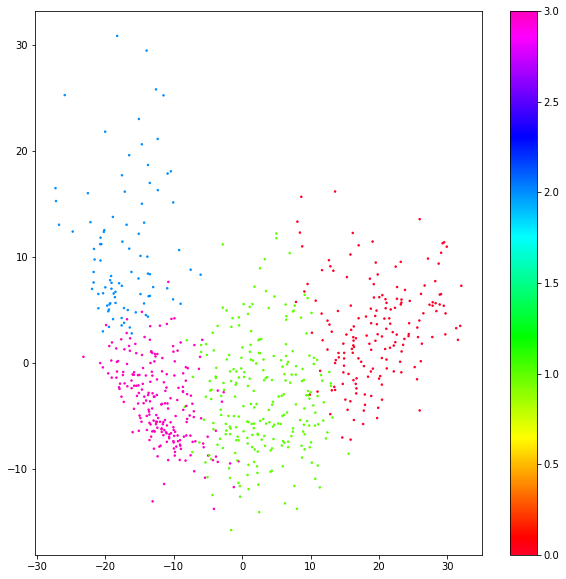

In [68]:
parse_results(km_pred, "km_4_flaubert", [])